In [94]:
#2 VARIABLES 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

class AnalizadorDatos:
    """
    Clase para el análisis de datos de un archivo .npy.
    Permite cargar los datos, dividirlos en entrenamiento y validación,
    calcular estadísticas descriptivas y generar histogramas con métricas.
    """

    def __init__(self, ruta_archivo):
        """
        Inicializa el analizador cargando los datos desde un archivo .npy.

        Parámetros:
        ruta_archivo (str): Ruta del archivo .npy con los datos.
        """
        self.ruta_archivo = ruta_archivo
        self.datos = None
        self.df = None
        self.entrenamiento = None
        self.validacion = None
        self.nombres_columnas = ["SalePrice", "OverallQual", "1stFlrSF", "TotRmsAbvGrd", "YearBuilt", "LotFrontage"]
        
        self.cargar_datos()

    def cargar_datos(self):
        """
        Carga los datos desde un archivo .npy, los convierte en un DataFrame de Pandas,
        y mezcla aleatoriamente las filas con una semilla fija para asegurar consistencia.
        """
        try:
            self.datos = np.load(self.ruta_archivo, allow_pickle=True)
            self.df = pd.DataFrame(self.datos, columns=self.nombres_columnas)

            # Mezclar las filas del DataFrame de forma reproducible
            self.df = self.df.sample(frac=1, random_state=42).reset_index(drop=True)

            # Tratar valores faltantes en LotFrontage
            if "LotFrontage" in self.df.columns:
                mediana = self.df["LotFrontage"].median()
                self.df["LotFrontage"].fillna(mediana, inplace=True)

            print("Datos cargados y mezclados correctamente.")
        except Exception as e:
            print(f"Error al cargar los datos: {e}")

    def dividir_datos(self, proporcion_entrenamiento=0.8):
        """
        Divide los datos mezclados en entrenamiento y validación.

        Parámetros:
        proporcion_entrenamiento (float): Proporción de los datos a utilizar para entrenamiento. 
        Por defecto es 0.8 (80%).
        """
        tamano_entrenamiento = int(len(self.df) * proporcion_entrenamiento)
        self.entrenamiento = self.df.iloc[:tamano_entrenamiento, :].copy()
        self.validacion = self.df.iloc[tamano_entrenamiento:, :].copy()
        print(f"Datos divididos en {tamano_entrenamiento} registros para entrenamiento y {len(self.df) - tamano_entrenamiento} para validación.")

    def calcular_estadisticas(self):
        """
            Calcula estadísticas descriptivas sobre los datos de entrenamiento.

            Retorna:
            pd.DataFrame: Un DataFrame con las estadísticas de cada columna, incluyendo:
            - Media
            - Máximo
            - Mínimo
            - Rango (peak-to-peak)
            - Desviación estándar
        """
        if self.entrenamiento is None:
            print("Primero ejecuta dividir_datos() antes de calcular estadísticas.")
            return None
        
        estadisticas = {
            "Media": np.mean(self.entrenamiento, axis=0),
            "Maximo": np.max(self.entrenamiento, axis=0),
            "Minimo": np.min(self.entrenamiento, axis=0),
            "Rango": np.ptp(self.entrenamiento, axis=0),  # Peak-to-peak (max - min)
            "DesviacionEstandar": np.std(self.entrenamiento, axis=0)
        }
        
        df_estadisticas = pd.DataFrame(estadisticas, index=self.nombres_columnas)
        return df_estadisticas
    
    def mostrar_cabecera(self, n=5):
        """
        Muestra las primeras 'n' filas del DataFrame.

        Parámetros:
        n (int): Número de filas a mostrar. Por defecto es 5.
        """
        print(self.df.head(n))

    def graficar_histogramas(self):
        """
        Genera histogramas para cada variable en el dataset, incluyendo:
        - Media (línea roja)
        - Mediana (línea azul)
        - Desviación estándar (líneas verdes en ±1σ)
        - Máximo y mínimo (marcadores)
        """
        for columna in self.nombres_columnas:
            datos = self.df[columna].dropna()  # Elimina valores nulos si los hay

            # Calcular estadísticas
            media = np.mean(datos)
            mediana = np.median(datos)
            desviacion = np.std(datos)
            minimo = np.min(datos)
            maximo = np.max(datos)

            # Crear histograma con seaborn
            plt.figure(figsize=(8, 5))
            sns.histplot(datos, kde=True, bins=30, color='lightseagreen')
            #lightseagreen, turquoise

            # Agregar líneas de estadísticas
            plt.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Media: {media:.2f}')
            plt.axvline(mediana, color='blue', linestyle='dashed', linewidth=2, label=f'Mediana: {mediana:.2f}')
            plt.axvline(media - desviacion, color='red', linestyle='dotted', linewidth=2, label=f'-1σ: {(media - desviacion):.2f}')
            plt.axvline(media + desviacion, color='orange', linestyle='dotted', linewidth=2, label=f'+1σ: {(media + desviacion):.2f}')

            # Marcar mínimo y máximo
            plt.scatter([minimo, maximo], [0, 0], color='black', zorder=3, label=f'Mín: {minimo:.2f}, Máx: {maximo:.2f}')

            # Configuración del gráfico
            plt.title(f"Histograma de {columna}")
            plt.xlabel(columna)
            plt.ylabel("Frecuencia")
            plt.legend()
            plt.grid(True)
            plt.show()

    def analizar_correlaciones(self):
        """
        Calcula y grafica la correlación entre cada variable independiente y la variable dependiente 'SalePrice'.
        Muestra un scatterplot por variable con su coeficiente de correlación en el título.
        Al final imprime las 2 variables con mayor correlación con 'SalePrice'.
        """
        if self.df is None:
            print("No hay datos cargados.")
            return

        variable_objetivo = "SalePrice"
        variables_independientes = [col for col in self.nombres_columnas if col != variable_objetivo]
        correlaciones = {}

        for variable in variables_independientes:
            x = self.df[variable]
            y = self.df[variable_objetivo]

            # Calcular correlación
            coef = np.corrcoef(x, y)[0, 1]
            correlaciones[variable] = coef

            # Graficar
            plt.figure(figsize=(7, 5))
            plt.scatter(x, y, alpha=0.6)
            plt.title(f"{variable} vs {variable_objetivo} (Correlación: {coef:.4f})")
            plt.xlabel(variable)
            plt.ylabel(variable_objetivo)
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Ordenar correlaciones absolutas de mayor a menor
        correlaciones_ordenadas = sorted(correlaciones.items(), key=lambda item: abs(item[1]), reverse=True)

        print("Variables con mayor correlación con SalePrice:")
        for variable, coef in correlaciones_ordenadas[:2]:
            print(f"{variable}: {coef:.4f}")
            
    def graficar_matriz_correlacion_personalizada(self):
        """
        Genera una matriz de correlación personalizada:
        - Parte inferior: scatterplots.
        - Parte superior: coeficiente de correlación (Pearson).
        - Solo se usan seaborn, matplotlib, numpy, pandas.
        """
        # Definir dimensiones
        columnas = self.df.columns
        num_vars = len(columnas)

        # Crear PairGrid
        grid = sns.PairGrid(self.df, vars=columnas, diag_sharey=False)

        # Parte inferior: scatterplot
        grid.map_lower(sns.scatterplot, s=10, alpha=0.6)

        # Parte superior: texto con coeficiente de correlación
        def correlacion(x, y, **kwargs):
            r = np.corrcoef(x, y)[0, 1]
            ax = plt.gca()
            ax.annotate(f"{r:.2f}", xy=(0.5, 0.5), xycoords=ax.transAxes,
                        ha='center', va='center', fontsize=12)

        grid.map_upper(correlacion)

        # Diagonal: histogramas
        grid.map_diag(sns.histplot, kde=True)

        plt.tight_layout()
        plt.show()
    
    def graficar_modelos(self, historial_parametros, X_original, y_original, cada_n=1000):
        """
        Grafica la evolución del modelo para múltiples variables, mostrando la curva respecto a la primera variable (x0),
        manteniendo fija la segunda (x1) en su media. Destaca iteraciones a partir de la 25000.

        Parámetros:
        historial_parametros (dict): {iteración: [beta_1, beta_2, ..., beta_0]}
        X_original (np.ndarray): Matriz original sin estandarizar (con variables y columna de unos al final)
        y_original (np.ndarray): Vector de salida real (sin estandarizar)
        cada_n (int): Iteraciones a graficar
        """
        x0 = X_original[:, 0]  # Primera variable: OverallQual
        x1_fijo = np.mean(X_original[:, 1])  # Mantener 1stFlrSF fijo en su media

        plt.figure(figsize=(8, 5))
        plt.scatter(x0, y_original, alpha=0.4, label="Datos reales")

        x_linea = np.linspace(np.min(x0), np.max(x0), 100)

        for iteracion, parametros in historial_parametros.items():
            *betas, beta_0_z = parametros

            # Desnormalizar coeficientes
            beta_1_real = (self.desv_y / self.desv_x[0]) * betas[0]
            beta_2_real = (self.desv_y / self.desv_x[1]) * betas[1]

            beta_0_real = (
                self.media_y + self.desv_y * beta_0_z
                - beta_1_real * self.media_x[0]
                - beta_2_real * self.media_x[1]
            )

            y_linea = beta_0_real + beta_1_real * x_linea + beta_2_real * x1_fijo

            color = "red" if iteracion >= 25000 else "gray"
            ancho = 2.5 if iteracion >= 25000 else 1.0
            estilo = "-" if iteracion >= 25000 else "--"
            alpha = 0.9 if iteracion >= 25000 else 0.4

            plt.plot(x_linea, y_linea, label=f"Iter {iteracion}", color=color,
                        linestyle=estilo, linewidth=ancho, alpha=alpha)

        plt.xlabel("OverallQual")
        plt.ylabel("SalePrice")
        plt.title("Evolución del modelo respecto a OverallQual")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

 
	
    def construir_matriz_entrada(self, variables_independientes, variable_dependiente, conjunto='entrenamiento'):
        """
        Parte del ejercicio: 7 (primera viñeta)

        Crea la matriz de entrada X extendida (con columna de unos) y el vector y correspondiente.

        Permite aplicar regresión lineal como un producto matricial:
        \n
        y_hat = X @ parametros

        Donde X es una matriz de shape (n, 2): [x, 1], y `parametros = [b1, b0]`

        Parámetros:
        variable_independiente (str): Nombre de la columna a usar como X.
        variable_dependiente (str): Nombre de la columna a usar como y.
        conjunto (str): Indica si se usa 'entrenamiento', 'validacion' o 'completo'. Por defecto es 'entrenamiento'.

        Retorna:
        tuple: (X, y)
            X: np.ndarray de shape (n, 2), con la variable independiente y una columna de unos
            y: np.ndarray de shape (n,), con la variable dependiente
        """
        if conjunto == 'entrenamiento':
            df = self.entrenamiento
        elif conjunto == 'validacion':
            df = self.validacion
        elif conjunto == 'completo':
            df = self.df
        else:
            raise ValueError("El conjunto debe ser 'entrenamiento', 'validacion' o 'completo'.")

        X = df[variables_independientes].to_numpy()
        X = np.column_stack([X, np.ones(len(X))])
        y = df[variable_dependiente].to_numpy()
        return X, y

    def graficar_curva_error(self, errores):
        """
        Grafica la evolución del error (RMSE) durante el entrenamiento del modelo vectorizado.

        Parámetros:
        errores (list): Lista con los valores del error (RMSE) por iteración.
        """
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(errores) + 1), errores, linewidth=2)
        plt.title("Curva de Error durante el Entrenamiento")
        plt.xlabel("Iteración")
        plt.ylabel("Error (RMSE)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    
    def entrenar_vectorizado_estandarizado(self, X, y, epochs, alpha, imprimir_error_cada=1000):
        """
        Entrena un modelo de regresión lineal con múltiples variables usando descenso por gradiente,
        aplicando estandarización (z-score) para cada variable.
        """
        n, d = X.shape
        d -= 1  # descontamos la columna de unos

        X_solo_variables = X[:, :-1]  # sin la columna de unos
        medias_x = np.mean(X_solo_variables, axis=0)
        desvs_x = np.std(X_solo_variables, axis=0)
        media_y = np.mean(y)
        desv_y = np.std(y)

        # Guardar estadísticas para desestandarización futura
        self.medias_x = medias_x
        self.desvs_x = desvs_x
        self.media_y = media_y
        self.desv_y = desv_y

        # Estandarizar X e Y
        X_norm = (X_solo_variables - medias_x) / desvs_x
        X_norm = np.column_stack([X_norm, np.ones(len(X))])
        y_norm = (y - media_y) / desv_y

        # Inicializar parámetros
        parametros = np.zeros(X_norm.shape[1])
        historial_parametros = {}
        errores = []

        for epoch in range(1, epochs + 1):
            y_pred = X_norm @ parametros
            error = y_pred - y_norm
            mse = np.mean(error ** 2) / 2
            rmse = np.sqrt(2 * mse)
            errores.append(rmse)

            gradiente = (1 / n) * X_norm.T @ error
            parametros -= alpha * gradiente

            if imprimir_error_cada > 0 and epoch % imprimir_error_cada == 0:
                historial_parametros[epoch] = parametros.copy()
                print(f"Iteración {epoch} - Error (RMSE): {rmse:.4f}")
                print(f"   Parámetros (estandarizados): {parametros}")

        self.parametros_estandarizados = parametros

        # ------------------------------
        # Imprimir fórmula desestandarizada
        coeficientes_originales = (self.desv_y / self.desvs_x) * parametros[:-1]
        intercepto_original = (
            self.media_y
            + self.desv_y * parametros[-1]
            - np.sum(coeficientes_originales * self.medias_x)
        )

        print("\n📌 Modelo final (escala original):")
        formula = f"   y = {intercepto_original:.4f}"
        for i, coef in enumerate(coeficientes_originales):
            formula += f" + ({coef:.4f}) * x{i+1}"
        print(formula)

        return historial_parametros, errores

    def entrenar_modelo_sklearn(self, X, y):
        """
        Entrena un modelo de regresión lineal utilizando scikit-learn.

        Parámetros:
        X (np.ndarray): Variables independientes (puede tener varias columnas)
        y (np.ndarray): Variable dependiente (vector 1D)

        Retorna:
        modelo_entrenado (LinearRegression): Objeto entrenado de sklearn
        """
        modelo = LinearRegression()
        modelo.fit(X, y)

        self.modelo_sklearn = modelo
        self.coeficientes_sklearn = modelo.coef_
        self.intercepto_sklearn = modelo.intercept_

        print("Modelo sklearn entrenado correctamente.")
        print(f"   Intercepto (β0): {self.intercepto_sklearn:.4f}")
        for idx, coef in enumerate(self.coeficientes_sklearn):
            print(f"   Coeficiente β{idx + 1}: {coef:.4f}")

        return modelo


    def predecir_comparacion_modelos(self, x_valores):
        """
        Realiza predicciones para nuevos valores usando:
        - El modelo propio entrenado con descenso por gradiente
        - El modelo de sklearn

        Parámetros:
        x_valores (np.ndarray): Matriz (n, d) de valores de variables independientes (sin columna de unos)

        Retorna:
        dict: predicciones de modelo propio, sklearn y promedio
        """
        x_valores = np.array(x_valores)
        if x_valores.ndim == 1:
            x_valores = x_valores.reshape(-1, 1)

        # Normalizar valores
        x_norm = (x_valores - self.medias_x) / self.desvs_x
        X_norm = np.column_stack([x_norm, np.ones(len(x_valores))])

        # Modelo propio (vectorizado)
        y_norm_pred = X_norm @ self.parametros_estandarizados
        y_pred_propio = y_norm_pred * self.desv_y + self.media_y

        # Modelo sklearn
        y_pred_sklearn = self.modelo_sklearn.predict(x_valores)

        # Promedio
        y_prom = (y_pred_propio + y_pred_sklearn) / 2
        
        return {
            "modelo_propio": y_pred_propio,
            "modelo_sklearn": y_pred_sklearn,
            "promedio": y_prom
        }
    
    def validar_modelos(self):
        """
        Evalúa y compara el desempeño de ambos modelos sobre el conjunto de validación.
        """
        if self.validacion is None:
            print("Falta dividir los datos.")
            return

        x_val = self.validacion[["OverallQual", "1stFlrSF"]].to_numpy()
        y_val_real = self.validacion["SalePrice"].to_numpy()

        # --- Modelo propio ---
        x_norm = (x_val - self.medias_x) / self.desvs_x
        X_val = np.column_stack([x_norm, np.ones(len(x_norm))])
        y_norm_pred = X_val @ self.parametros_estandarizados
        y_pred_propio = y_norm_pred * self.desv_y + self.media_y

        # --- Modelo sklearn ---
        y_pred_sklearn = self.modelo_sklearn.predict(x_val)

        # RMSE
        rmse_propio = np.sqrt(np.mean((y_val_real - y_pred_propio) ** 2))
        rmse_sklearn = np.sqrt(np.mean((y_val_real - y_pred_sklearn) ** 2))

        print("VALIDACIÓN CONJUNTO 20%")
        print(f"  RMSE modelo propio: {rmse_propio:.2f}")
        print(f"  RMSE modelo sklearn: {rmse_sklearn:.2f}")
        print("✅ Modelo que generaliza mejor:", "propio" if rmse_propio < rmse_sklearn else "sklearn")
        return rmse_propio, rmse_sklearn

    def analizar_predicciones_validacion(self):
        """
        Compara gráficamente las predicciones de ambos modelos con los valores reales en el conjunto de validación.
        """
        x_val = self.validacion[["OverallQual", "1stFlrSF"]].to_numpy()
        y_val_real = self.validacion["SalePrice"].to_numpy()

        # Modelo propio
        x_norm = (x_val - self.medias_x) / self.desvs_x
        X_val = np.column_stack([x_norm, np.ones(len(x_norm))])
        y_norm_pred = X_val @ self.parametros_estandarizados
        y_pred_propio = y_norm_pred * self.desv_y + self.media_y

        # Modelo sklearn
        y_pred_sklearn = self.modelo_sklearn.predict(x_val)

        # R²
        r2_propio = r2_score(y_val_real, y_pred_propio)
        r2_sklearn = r2_score(y_val_real, y_pred_sklearn)

        # Error absoluto
        error_propio = np.abs(y_val_real - y_pred_propio)
        error_sklearn = np.abs(y_val_real - y_pred_sklearn)

        # Tabla
        print("Índice | Real | Propio | Sklearn | Error propio | Error sklearn")
        for i in range(len(y_val_real)):
            print(f"{i:6} | {y_val_real[i]:7.0f} | {y_pred_propio[i]:7.0f} | {y_pred_sklearn[i]:8.0f} | {error_propio[i]:12.2f} | {error_sklearn[i]:14.2f}")

        # Gráfico 1
        plt.figure(figsize=(10, 5))
        plt.plot(y_val_real, label="Valor real", color='blue', linewidth=2)
        plt.plot(y_pred_propio, label="Modelo propio", color='red')
        plt.plot(y_pred_sklearn, label="Modelo sklearn", color='purple', linestyle='--')
        plt.title("Predicciones vs Valor Real")
        plt.xlabel("Índice")
        plt.ylabel("SalePrice")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Gráfico 2
        plt.figure(figsize=(10, 5))
        plt.plot(error_propio, label="Error modelo propio", color='red')
        plt.plot(error_sklearn, label="Error modelo sklearn", color='purple')
        plt.title("Error absoluto por índice")
        plt.xlabel("Índice")
        plt.ylabel("Error absoluto")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"\nR² modelo propio: {r2_propio:.4f}")
        print(f"R² modelo sklearn: {r2_sklearn:.4f}")




In [95]:
#Paso 1. Crear instancia y cargar datos
ruta_archivo = r"C:\PythonWs\Proyecto\proyecto_training_data.npy"
analizador = AnalizadorDatos(ruta_archivo)

Datos cargados y mezclados correctamente.


C:\Users\EC\AppData\Local\Temp\ipykernel_25484\1350085009.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df["LotFrontage"].fillna(mediana, inplace=True)


In [96]:
analizador.dividir_datos(proporcion_entrenamiento=0.8)

Datos divididos en 1168 registros para entrenamiento y 292 para validación.


In [71]:
# Calcular y mostrar estadísticas descriptivas
estadisticas = analizador.calcular_estadisticas()
print(estadisticas)

                      Media    Maximo   Minimo     Rango  DesviacionEstandar
SalePrice     181081.876712  755000.0  34900.0  720100.0        81096.489736
OverallQual        6.095034      10.0      1.0       9.0            1.402802
1stFlrSF        1161.268836    4692.0    334.0    4358.0          393.372616
TotRmsAbvGrd       6.532534      14.0      2.0      12.0            1.626715
YearBuilt       1971.120719    2009.0   1872.0     137.0           30.266595
LotFrontage       70.049658     313.0     21.0     292.0           22.723041


In [ ]:
analizador.graficar_histogramas()

In [ ]:
# 5. Para cada variable independiente x :
analizador.analizar_correlaciones()

In [ ]:
analizador.graficar_matriz_correlacion_personalizada()

In [97]:
# 6.1 y 6.2: Construir matriz extendida con columna de unos (múltiples variables)
X, y = analizador.construir_matriz_entrada(["OverallQual", "1stFlrSF"], "SalePrice", conjunto="entrenamiento")

# 6.3: Entrenar modelo vectorizado estandarizado
historial, errores = analizador.entrenar_vectorizado_estandarizado(X, y, epochs=500, alpha=0.01, imprimir_error_cada=50)


Iteración 50 - Error (RMSE): 0.6935
   Parámetros (estandarizados): [2.89914451e-01 2.05513421e-01 5.52425401e-17]
Iteración 100 - Error (RMSE): 0.5948
   Parámetros (estandarizados): [4.40097148e-01 2.90760672e-01 7.97387330e-17]
Iteración 150 - Error (RMSE): 0.5674
   Parámetros (estandarizados): [5.21015551e-01 3.21719826e-01 9.04181244e-17]
Iteración 200 - Error (RMSE): 0.5594
   Parámetros (estandarizados): [5.66816477e-01 3.29083707e-01 9.90743945e-17]
Iteración 250 - Error (RMSE): 0.5566
   Parámetros (estandarizados): [5.94234690e-01 3.26929692e-01 1.07062796e-16]
Iteración 300 - Error (RMSE): 0.5554
   Parámetros (estandarizados): [6.11613493e-01 3.21556570e-01 1.10805462e-16]
Iteración 350 - Error (RMSE): 0.5547
   Parámetros (estandarizados): [6.23218375e-01 3.15656850e-01 1.10926893e-16]
Iteración 400 - Error (RMSE): 0.5544
   Parámetros (estandarizados): [6.31307676e-01 3.10278673e-01 1.11122049e-16]
Iteración 450 - Error (RMSE): 0.5542
   Parámetros (estandarizados): [6.3

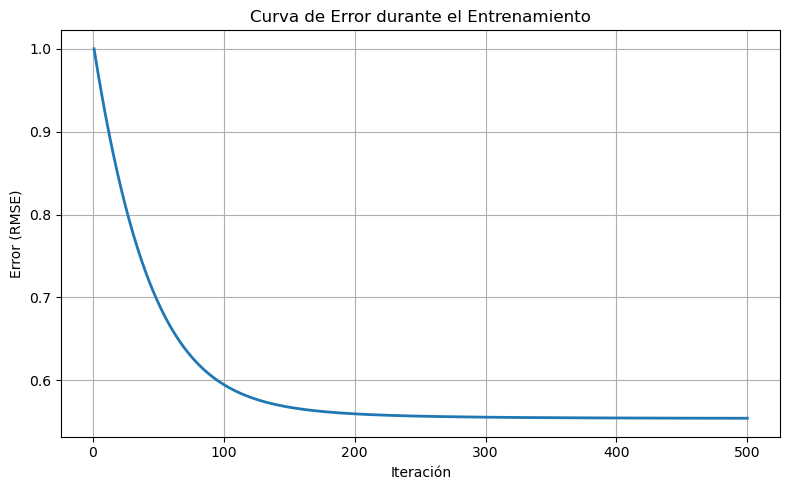

In [98]:
analizador.graficar_curva_error(errores)

In [99]:
x_sklearn = X[:, :-1]  # sin columna de unos
analizador.entrenar_modelo_sklearn(x_sklearn, y)


Modelo sklearn entrenado correctamente.
   Intercepto (β0): -118908.8072
   Coeficiente β1: 37865.7014
   Coeficiente β2: 59.5882


LinearRegression()

In [100]:
analizador.validar_modelos()

VALIDACIÓN CONJUNTO 20%
  RMSE modelo propio: 39857.00
  RMSE modelo sklearn: 39932.30
✅ Modelo que generaliza mejor: propio


(np.float64(39857.002777779926), np.float64(39932.299523214795))

Índice | Real | Propio | Sklearn | Error propio | Error sklearn
     0 |  210000 |  162222 |   162809 |     47777.80 |       47191.38
     1 |   97500 |  162035 |   162630 |     64535.38 |       65129.85
     2 |  165000 |  181464 |   181221 |     16464.32 |       16221.38
     3 |  213490 |  236106 |   235891 |     22616.09 |       22400.95
     4 |  137900 |  201176 |   197700 |     63275.61 |       59800.13
     5 |  155000 |  185666 |   187625 |     30665.58 |       32624.50
     6 |  466500 |  417530 |   416644 |     48970.09 |       49856.02
     7 |  244600 |  270821 |   271492 |     26220.75 |       26892.30
     8 |  110000 |  116299 |   116481 |      6298.54 |        6481.39
     9 |  112000 |  107394 |   107960 |      4606.39 |        4039.72
    10 |  134800 |  124207 |   124049 |     10592.88 |       10750.91
    11 |  119000 |  161537 |   162153 |     42537.20 |       43153.15
    12 |  223000 |  220073 |   218166 |      2926.89 |        4833.93
    13 |  192500 |  239157

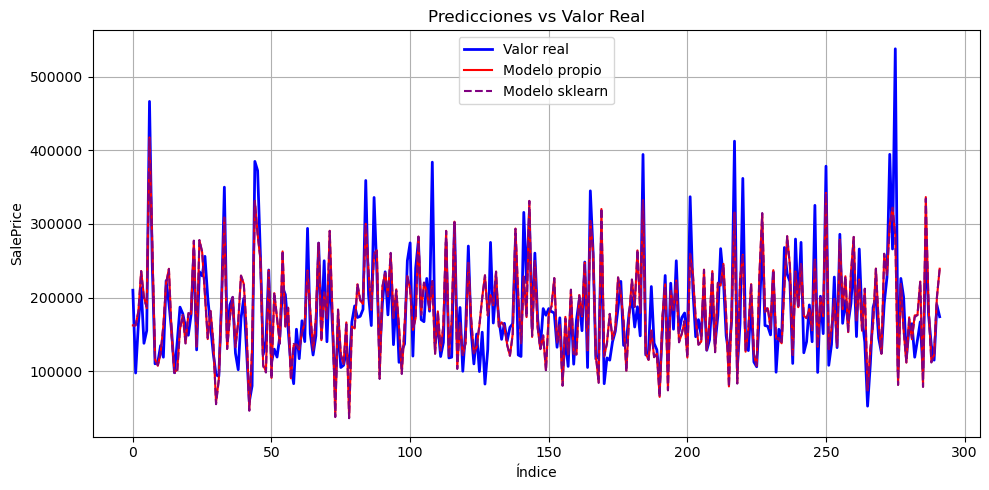

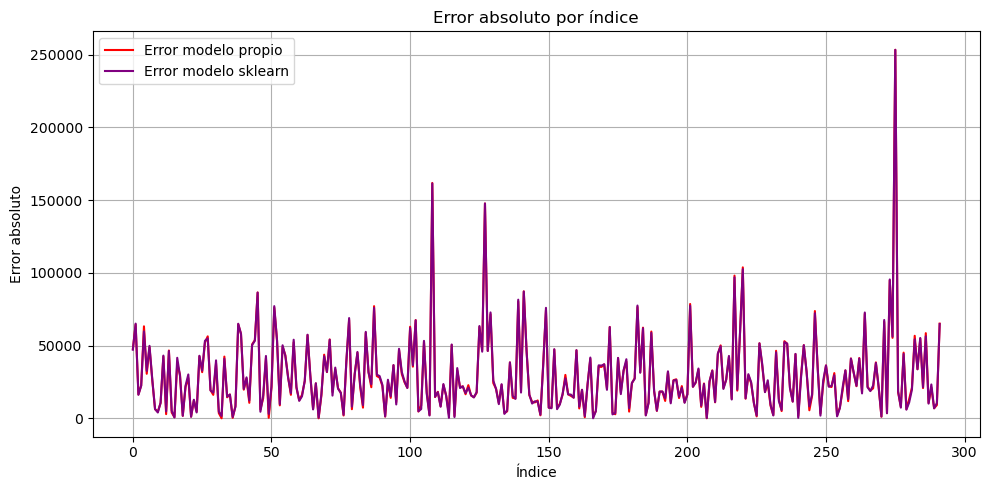


R² modelo propio: 0.6961
R² modelo sklearn: 0.6949


In [101]:
analizador.analizar_predicciones_validacion()

In [102]:
analizador.validacion.head(5)


,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
1168,210000.0,6.0,915.0,6.0,1923.0,70.0
1169,97500.0,6.0,912.0,6.0,1948.0,78.0
1170,165000.0,6.0,1224.0,5.0,1999.0,69.0
1171,213490.0,7.0,1506.0,6.0,2005.0,43.0
1172,137900.0,5.0,2136.0,7.0,1951.0,89.0


In [103]:
nuevos = [[6, 915.0], [7, 1506.0], [5, 2136.0]]
analizador.predecir_comparacion_modelos(nuevos)

{'modelo_propio': array([162222.19842177, 236106.09450341, 201175.61212659]),
 'modelo_sklearn': array([162808.61796548, 235890.95447358, 197700.12717698]),
 'promedio': array([162515.40819363, 235998.52448849, 199437.86965179])}